In [1]:
import warnings
warnings.filterwarnings('ignore')
import squidpy as sq
import scanpy as sc

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

<h1> Niche calculations </h1>

load example data with cell type annotation:

In [3]:
adata = sc.read_h5ad("C://Users//laure//Desktop//github//donor_wildtype.h5ad")
adata = adata[adata.obs["category"] == "wildtype"] # only using one slide for now

Every niche method requires a spatial neighborhood graph, which is why `sq.gr.spatial_neighbors` needs to be run first.

In [4]:
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=False, n_neighs=40)

Some niche detection methods require a previous (celltype) annotation. Here we imitate one using leiden clusters:

In [5]:
sc.pp.neighbors(adata, n_neighbors=40)
sc.tl.leiden(adata, resolution=1)
adata.obs.drop(adata.obs.columns.difference(['leiden']), axis=1, inplace=True)

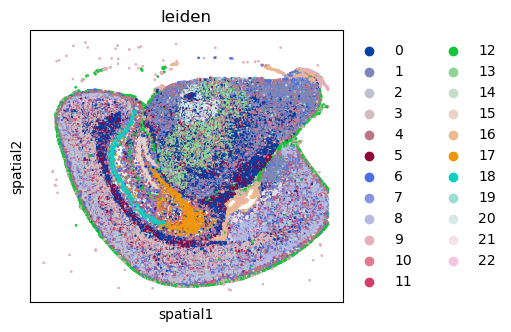

In [6]:
sq.pl.spatial_scatter(
    adata, color="leiden", shape=None, figsize=(5, 5)
)

<h1> Neighborhood approach </h1>
<br/>
Let's begin with the neighborhood profile clustering approach. It allows to mask low quality cells (they won't be assigned a niche) and specify a cluster which we don't want to use for neighborhood profile calculation. Here we mask cluster 18 as an example and refrain from using cluster 17 for nhood-profile calculation.

In [7]:
mask = ~adata.obs['leiden'].isin([
    '18'
])

In [8]:
sq.gr.calculate_niche(adata, groups="leiden", flavor="neighborhood", n_neighbors=40, resolutions=[0.5, 1], subset_groups=["17"], mask=mask, min_niche_size=50)

The niche result is now stored in `adata.obs`

In [9]:
adata.obs

leiden neighborhood_niche_res=0.5 neighborhood_niche_res=1
0-1         12                          9                       11
1-1          9                          9                       11
2-1          2                          8                        2
3-1         11                          8                        2
4-1          2                          8                        2
...        ...                        ...                      ...
58680-1     12                          9                       11
58681-1      9                          9                       11
58682-1      9                          9                       11
58683-1     12                          9                       11
58684-1      9                          9                       11

[58685 rows x 3 columns]

Visualize the result by comparing it to the cell type annotation:

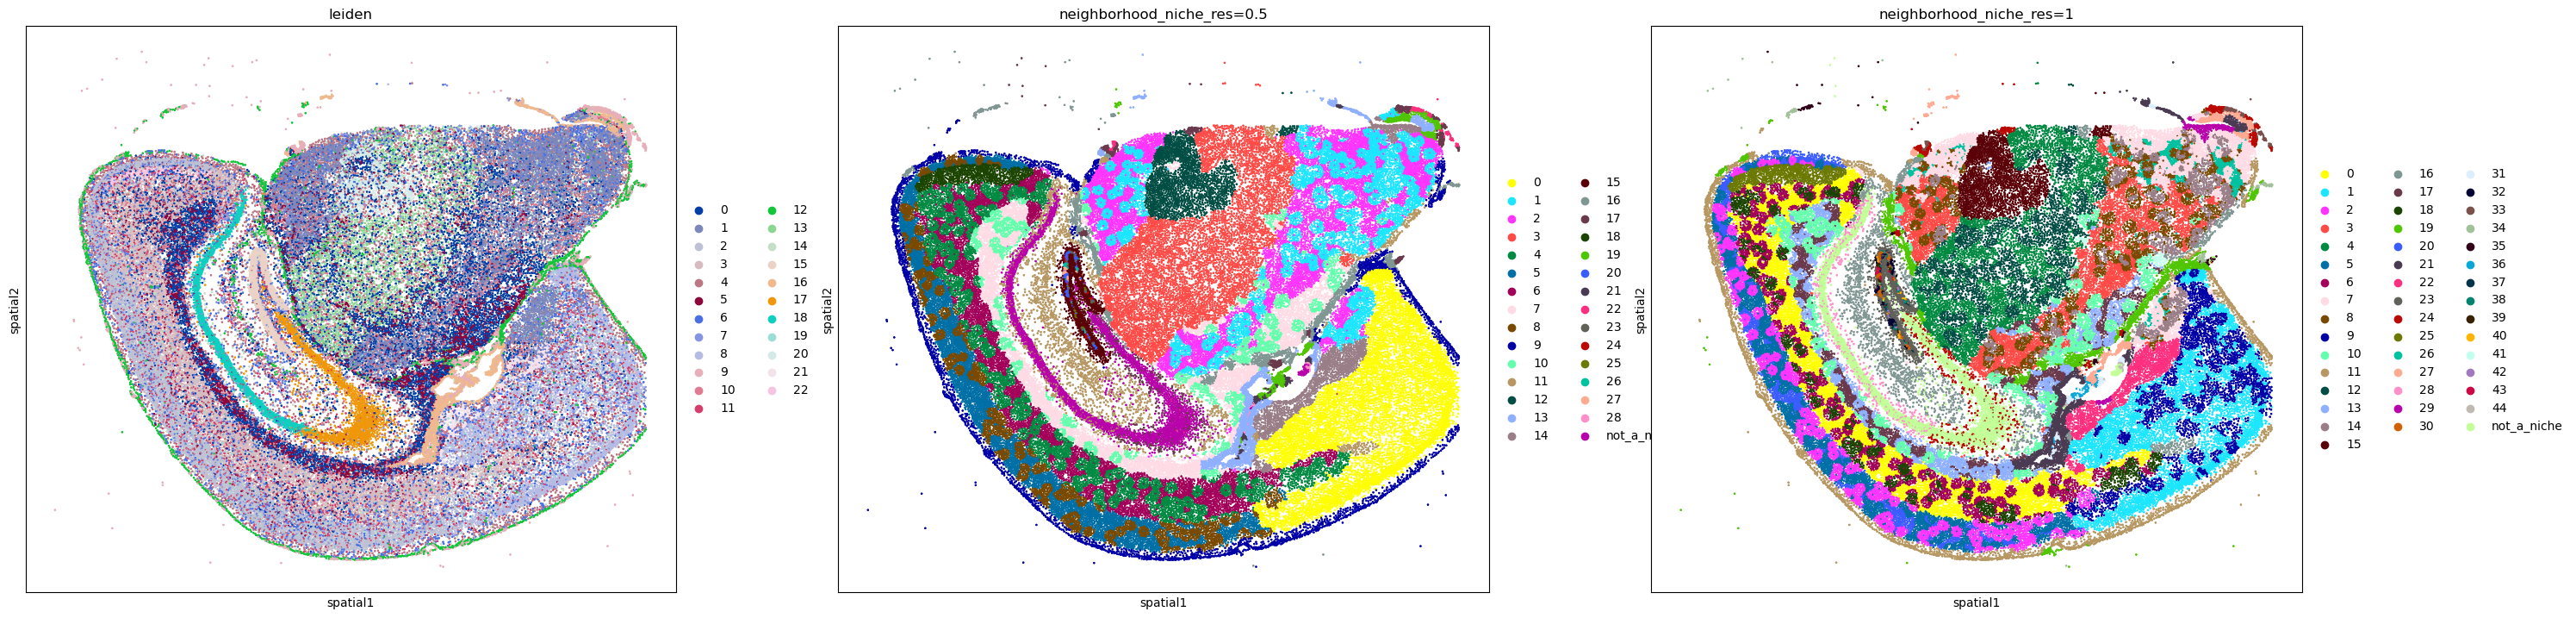

In [10]:
sq.pl.spatial_scatter(
    adata, color=["leiden","neighborhood_niche_res=0.5","neighborhood_niche_res=1"], shape=None, figsize=(10, 10)
)

<h1> UTAG </h1>
<br/>
Next we follow the UTAG approach, which involves the count matrix stored in adata.X.

In [11]:
sq.gr.calculate_niche(adata, groups="leiden", flavor="utag", n_neighbors=15, resolutions=[0.1,0.5,1])

The new count matrix is stored in a different layer.

In [12]:
adata.obs

leiden neighborhood_niche_res=0.5 neighborhood_niche_res=1  \
0-1         12                          9                       11   
1-1          9                          9                       11   
2-1          2                          8                        2   
3-1         11                          8                        2   
4-1          2                          8                        2   
...        ...                        ...                      ...   
58680-1     12                          9                       11   
58681-1      9                          9                       11   
58682-1      9                          9                       11   
58683-1     12                          9                       11   
58684-1      9                          9                       11   

        utag_res=0.1 utag_res=0.5 utag_res=1  
0-1               14           20         38  
1-1               14           20         38  
2-1                0            2         19  
3-1                0            2         19  
4-1                0            2         19  
...              ...          ...        ...  
58680-1            6           40         56  
58681-1            6           40         56  
58682-1            6           40         56  
58683-1            6           40         56  
58684-1            6           40         56  

[58685 rows x 6 columns]

Visualize the result:

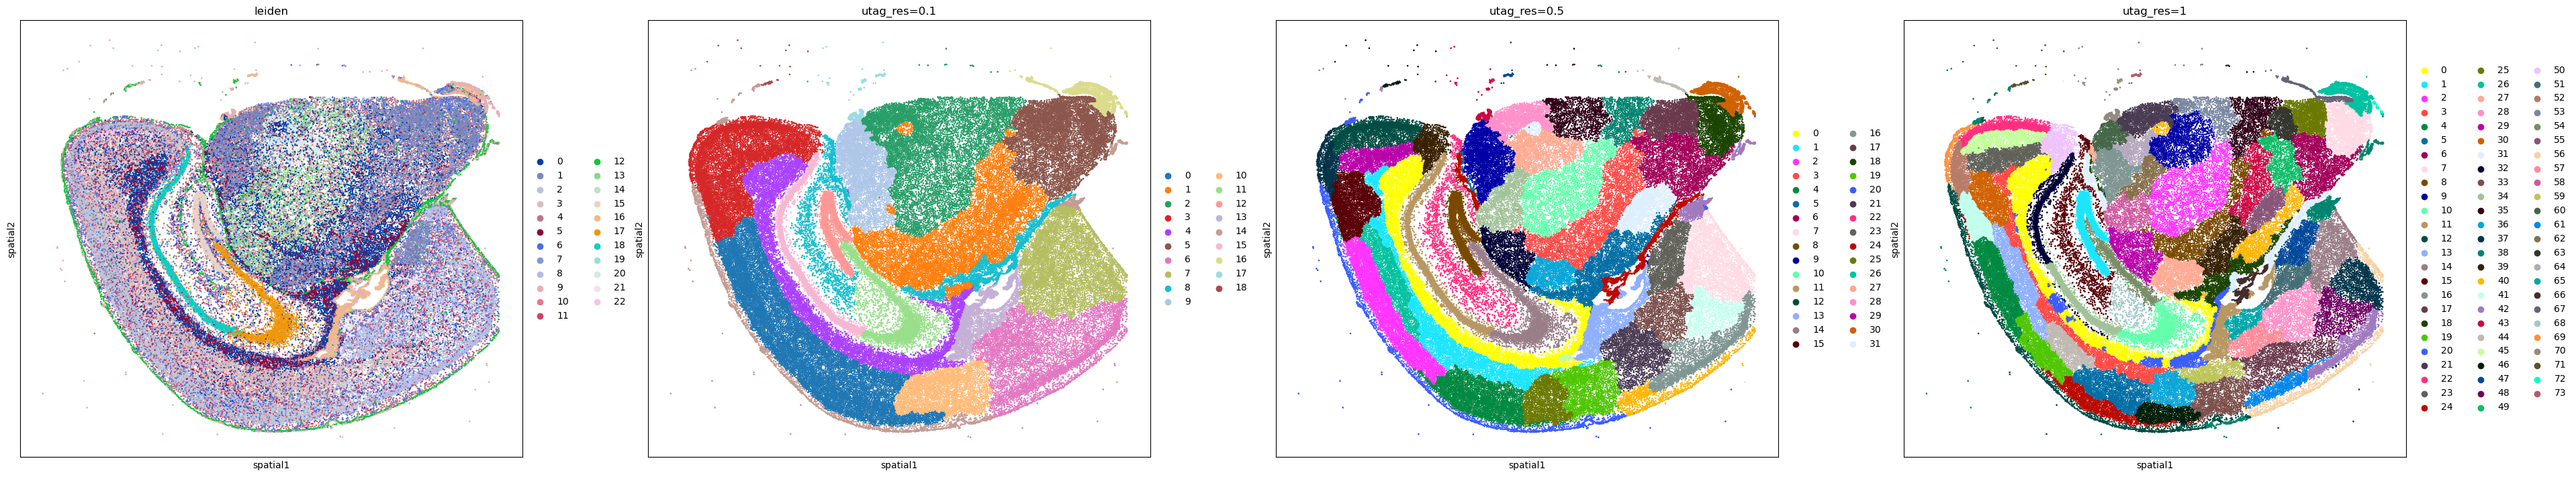

In [13]:
sq.pl.spatial_scatter(
    adata, color=["leiden","utag_res=0.1","utag_res=0.5","utag_res=1"], shape=None, figsize=(10, 10)
)

<h1> Cellcharter </h1>
<br/>
For the Cellcharter approach, multiple neighborhood based matrices are aggregated, dimensionality reduced, then clustered. The advantage of this method is, it doesn't require any annotation and we can decide the amount of niches we expect. 

Here we choose 5 clusters and aggregate 3 n-hop neighbor matrices.

In [14]:
sq.gr.calculate_niche(adata, flavor="cellcharter", n_components=5, distance=3)

In [15]:
adata.obs

leiden neighborhood_niche_res=0.5 neighborhood_niche_res=1  \
0-1         12                          9                       11   
1-1          9                          9                       11   
2-1          2                          8                        2   
3-1         11                          8                        2   
4-1          2                          8                        2   
...        ...                        ...                      ...   
58680-1     12                          9                       11   
58681-1      9                          9                       11   
58682-1      9                          9                       11   
58683-1     12                          9                       11   
58684-1      9                          9                       11   

        utag_res=0.1 utag_res=0.5 utag_res=1 cellcharter_niche  
0-1               14           20         38                 3  
1-1               14           20         38                 3  
2-1                0            2         19                 2  
3-1                0            2         19                 2  
4-1                0            2         19                 2  
...              ...          ...        ...               ...  
58680-1            6           40         56                 3  
58681-1            6           40         56                 3  
58682-1            6           40         56                 3  
58683-1            6           40         56                 3  
58684-1            6           40         56                 3  

[58685 rows x 7 columns]

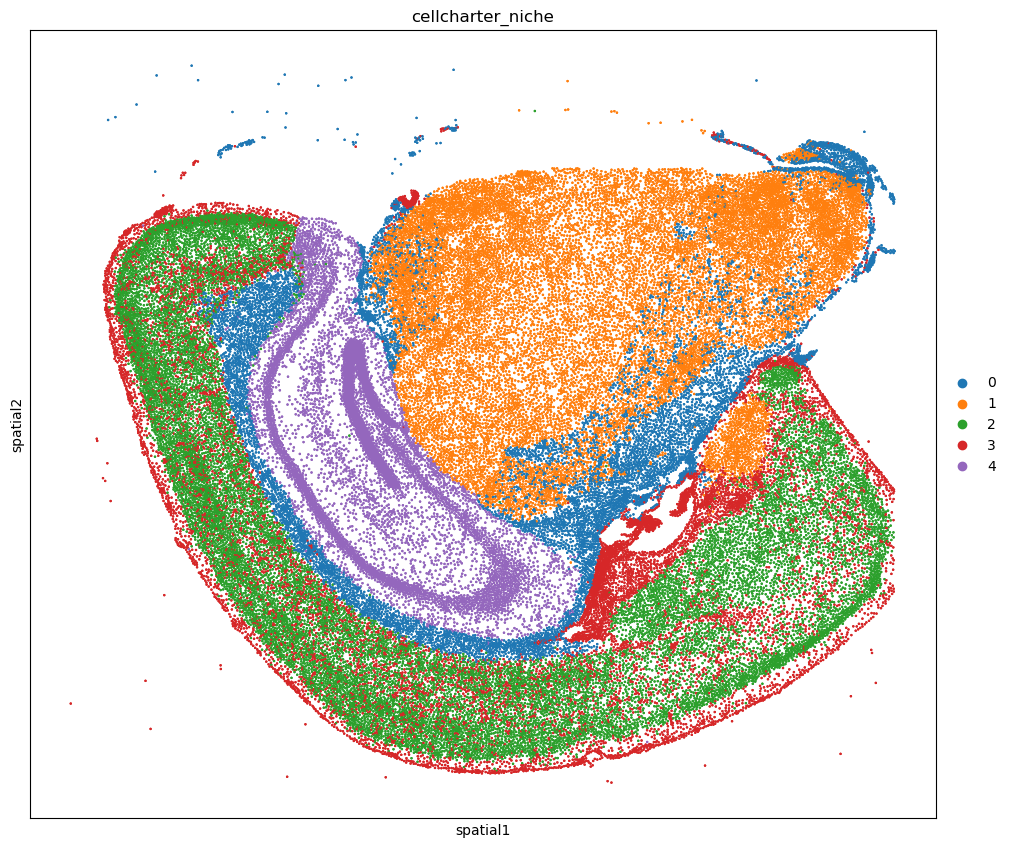

In [16]:
sq.pl.spatial_scatter(
    adata, color=["cellcharter_niche"], shape=None, figsize=(10, 10)
)

TODO:
- adjust for slides
- use pymc for GMM in cellcharter approach
- use different dim-reduction in cellcharter approach